<a href="https://colab.research.google.com/github/ArmaanAryan/Monte-Carlo-Simulation-for-Nvidia-Options-pricing/blob/main/Nvidia_MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import erf

In [ ]:
np.random.seed(42)

In [ ]:
ticker = yf.Ticker("NVDA")
historical_data = ticker.history(period="5y")

print(historical_data.head())

                               Open      High       Low     Close     Volume  \
Date                                                                           
2020-04-15 00:00:00-04:00  6.904562  7.078172  6.859229  6.995228  366148000   
2020-04-16 00:00:00-04:00  7.150655  7.447561  7.137454  7.340456  745620000   
2020-04-17 00:00:00-04:00  7.422653  7.444074  7.147168  7.281174  539120000   
2020-04-20 00:00:00-04:00  7.154640  7.310565  7.105571  7.149907  449388000   
2020-04-21 00:00:00-04:00  7.031842  7.093116  6.653237  6.713017  735160000   

                           Dividends  Stock Splits  
Date                                                
2020-04-15 00:00:00-04:00        0.0           0.0  
2020-04-16 00:00:00-04:00        0.0           0.0  
2020-04-17 00:00:00-04:00        0.0           0.0  
2020-04-20 00:00:00-04:00        0.0           0.0  
2020-04-21 00:00:00-04:00        0.0           0.0  


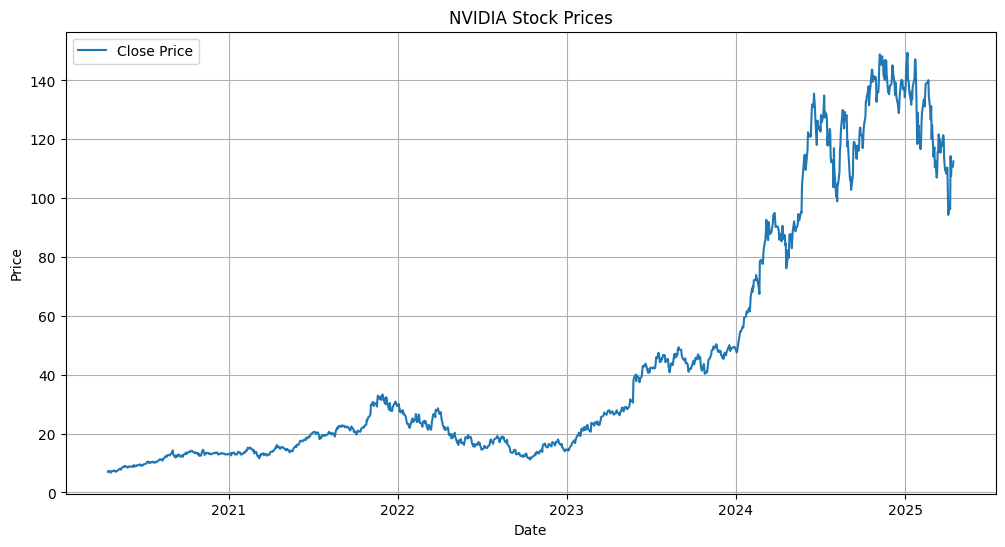

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(historical_data.index, historical_data['Close'], label='Close Price')
plt.title('NVIDIA Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
returns = np.log(historical_data['Close'] / historical_data['Close'].shift(1)).dropna()
historical_volatility = returns.std() * np.sqrt(252)
print(f"Historical Volatility: {historical_volatility:.4f}")


current_price = historical_data['Close'].iloc[-1]
print(f"Current Stock Price: ${current_price:.2f}")

Historical Volatility: 0.5266
Current Stock Price: $112.51


In [ ]:
class Black_Scholes:
    def __init__(self, stock_price, strike_price, riskfree_rate, volatility, time_to_maturity):
        self.S = stock_price
        self.K = strike_price
        self.r = riskfree_rate
        self.sigma = volatility
        self.T = time_to_maturity

    def calculate_d1(self):
        numerator = np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T
        denominator = self.sigma * np.sqrt(self.T)
        return numerator / denominator

    def calculate_d2(self, d1):
        return d1 - self.sigma * np.sqrt(self.T)

    def call_option_price(self):
        d1 = self.calculate_d1()
        d2 = self.calculate_d2(d1)
        option_price = (self.S * self.N(d1)) - (self.K * np.exp(-self.r * self.T) * self.N(d2))
        return option_price

    def put_option_price(self):
        d1 = self.calculate_d1()
        d2 = self.calculate_d2(d1)
        option_price = (self.K * np.exp(-self.r * self.T) * self.N(-d2)) - (self.S * self.N(-d1))
        return option_price

    def N(self, x):
        return (1 + erf(x / np.sqrt(2))) / 2

    def delta_call(self):
        d1 = self.calculate_d1()
        return self.N(d1)

    def delta_put(self):
        d1 = self.calculate_d1()
        return self.N(d1) - 1

    def gamma(self):
        d1 = self.calculate_d1()
        return np.exp(-d1**2/2) / (self.S * self.sigma * np.sqrt(2 * np.pi * self.T))



In [ ]:
class MonteCarlo:
    def __init__(self, stock_price, strike_price, riskfree_rate, volatility, time_to_maturity, num_simulations, num_steps):
        self.S = stock_price
        self.K = strike_price
        self.r = riskfree_rate
        self.sigma = volatility
        self.T = time_to_maturity
        self.N = num_simulations
        self.M = num_steps

    def price_paths(self):
        dt = self.T / self.M
        price = np.zeros((self.M + 1, self.N))
        price[0] = self.S
        for t in range(1, self.M + 1):
            rand_values = np.random.randn(self.N)
            price[t] = price[t - 1] * np.exp((self.r - 0.5 * self.sigma ** 2) * dt + self.sigma * np.sqrt(dt) * rand_values)
        return price

    def price_paths_antithetic(self):
        dt = self.T / self.M
        price_up = np.zeros((self.M + 1, self.N//2))
        price_down = np.zeros((self.M + 1, self.N//2))

        price_up[0] = self.S
        price_down[0] = self.S

        for t in range(1, self.M + 1):
            rand_values = np.random.randn(self.N//2)
            price_up[t] = price_up[t-1] * np.exp((self.r - 0.5 * self.sigma**2) * dt +
                                              self.sigma * np.sqrt(dt) * rand_values)
            price_down[t] = price_down[t-1] * np.exp((self.r - 0.5 * self.sigma**2) * dt +
                                                 self.sigma * np.sqrt(dt) * (-rand_values))

        price = np.hstack((price_up, price_down))
        return price

    def call_montecarlo(self, antithetic=False):
        price = self.price_paths_antithetic() if antithetic else self.price_paths()
        payoffs = np.maximum(price[-1] - self.K, 0)
        option_price = np.exp(-self.r * self.T) * np.mean(payoffs)
        return option_price

    def put_montecarlo(self, antithetic=False):
        price = self.price_paths_antithetic() if antithetic else self.price_paths()
        payoffs = np.maximum(self.K - price[-1], 0)
        option_price = np.exp(-self.r * self.T) * np.mean(payoffs)
        return option_price

    def plot_price_paths(self, price_paths, num_paths_to_plot=50):
        plt.figure(figsize=(12, 6))
        time_steps = np.linspace(0, self.T, self.M + 1)
        paths_to_plot = min(num_paths_to_plot, self.N)
        colors = plt.cm.jet(np.linspace(0, 1, paths_to_plot))

        for i in range(paths_to_plot):
            plt.plot(time_steps, price_paths[:, i], '-', color=colors[i], alpha=0.5,
                     label='Simulated Path' if i == 0 else '')

        mean_path = np.mean(price_paths, axis=1)
        plt.plot(time_steps, mean_path, 'k-', linewidth=2, label='Mean Path')

        plt.title('Monte Carlo Simulation: Stock Price Paths')
        plt.xlabel('Time (Years)')
        plt.ylabel('Stock Price ($)')
        plt.legend()
        plt.grid(True)
        plt.show()


In [ ]:
class BinomialTree:
    def __init__(self, stock_price, strike_price, riskfree_rate, volatility, time_to_maturity, steps):
        self.S = stock_price
        self.K = strike_price
        self.r = riskfree_rate
        self.sigma = volatility
        self.T = time_to_maturity
        self.N = steps

    def price_american_option(self, option_type='call'):
        dt = self.T / self.N
        u = np.exp(self.sigma * np.sqrt(dt))
        d = 1/u
        p = (np.exp(self.r * dt) - d) / (u - d)

        prices = np.zeros((self.N + 1, self.N + 1))
        prices[0, 0] = self.S

        for i in range(1, self.N + 1):
            prices[i, 0] = prices[i-1, 0] * u
            for j in range(1, i + 1):
                prices[i, j] = prices[i-1, j-1] * d

        option = np.zeros((self.N + 1, self.N + 1))
        for j in range(self.N + 1):
            if option_type == 'call':
                option[self.N, j] = max(0, prices[self.N, j] - self.K)
            else:
                option[self.N, j] = max(0, self.K - prices[self.N, j])

        for i in range(self.N - 1, -1, -1):
            for j in range(i + 1):
                hold_value = np.exp(-self.r * dt) * (p * option[i+1, j] + (1-p) * option[i+1, j+1])
                if option_type == 'call':
                    exercise_value = max(0, prices[i, j] - self.K)
                else:
                    exercise_value = max(0, self.K - prices[i, j])
                option[i, j] = max(hold_value, exercise_value)

        return option[0, 0]

In [ ]:
def implied_volatility(option_price, S, K, r, T, option_type='call', precision=0.0001, max_iterations=100):
    sigma_low = 0.001
    sigma_high = 2.0

    for i in range(max_iterations):
        sigma_mid = (sigma_low + sigma_high) / 2
        bs = Black_Scholes(S, K, r, sigma_mid, T)

        if option_type == 'call':
            price = bs.call_option_price()
        else:
            price = bs.put_option_price()

        price_diff = price - option_price

        if abs(price_diff) < precision:
            return sigma_mid

        if price_diff > 0:
            sigma_high = sigma_mid
        else:
            sigma_low = sigma_mid

    return (sigma_low + sigma_high) / 2

In [ ]:
stock_price = current_price
strike_price = round(current_price)
riskfree_rate = 0.05
volatility = historical_volatility
time_to_maturity = 1.0
num_simulations = 10000
num_steps = 100
binomial_steps = 100

In [ ]:
bs_model = Black_Scholes(stock_price, strike_price, riskfree_rate, volatility, time_to_maturity)
mc_model = MonteCarlo(stock_price, strike_price, riskfree_rate, volatility, time_to_maturity, num_simulations, num_steps)
bt_model = BinomialTree(stock_price, strike_price, riskfree_rate, volatility, time_to_maturity, binomial_steps)

In [ ]:
bs_call_price = bs_model.call_option_price()
bs_put_price = bs_model.put_option_price()
mc_call_price = mc_model.call_montecarlo(antithetic=True)
mc_put_price = mc_model.put_montecarlo(antithetic=True)
bt_call_price = bt_model.price_american_option(option_type='call')
bt_put_price = bt_model.price_american_option(option_type='put')

In [ ]:
bs_delta_call = bs_model.delta_call()
bs_delta_put = bs_model.delta_put()
bs_gamma = bs_model.gamma()

In [ ]:
iv_call = implied_volatility(bs_call_price, stock_price, strike_price, riskfree_rate, time_to_maturity, option_type='call')
iv_put = implied_volatility(bs_put_price, stock_price, strike_price, riskfree_rate, time_to_maturity, option_type='put')

In [ ]:
print("\nOption Pricing Results:")
print(f"Stock Price: ${stock_price:.2f}")
print(f"Strike Price: ${strike_price:.2f}")
print(f"Black-Scholes Call Price: ${bs_call_price:.4f}")
print(f"Black-Scholes Put Price: ${bs_put_price:.4f}")
print(f"Monte Carlo Call Price (Antithetic): ${mc_call_price:.4f}")
print(f"Monte Carlo Put Price (Antithetic): ${mc_put_price:.4f}")
print(f"Binomial Tree American Call Price: ${bt_call_price:.4f}")
print(f"Binomial Tree American Put Price: ${bt_put_price:.4f}")
print(f"Delta Call: {bs_delta_call:.4f}")
print(f"Delta Put: {bs_delta_put:.4f}")
print(f"Gamma: {bs_gamma:.4f}")
print(f"Implied Volatility (Call): {iv_call:.4f}")
print(f"Implied Volatility (Put): {iv_put:.4f}")


Option Pricing Results:
Stock Price: $112.51
Strike Price: $113.00
Black-Scholes Call Price: $25.4437
Black-Scholes Put Price: $20.4177
Monte Carlo Call Price (Antithetic): $25.2965
Monte Carlo Put Price (Antithetic): $20.5348
Binomial Tree American Call Price: $25.4039
Binomial Tree American Put Price: $21.0137
Delta Call: 0.6369
Delta Put: -0.3631
Gamma: 0.0063
Implied Volatility (Call): 0.5266
Implied Volatility (Put): 0.5266


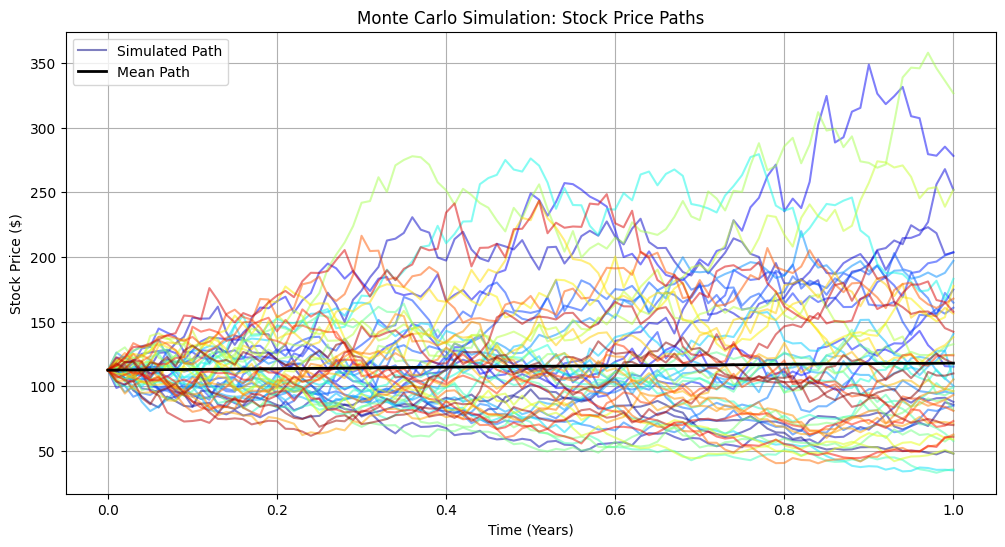

In [ ]:
price_paths = mc_model.price_paths_antithetic()
mc_model.plot_price_paths(price_paths, num_paths_to_plot=50)